In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.colors

In [2]:
# Settings and labels
colors = {
    'low': matplotlib.colors.hex2color('#898C1C'),
    'high':  matplotlib.colors.hex2color('#541C8C'),
    # opposite color
    'observed':  matplotlib.colors.hex2color('#278C80')
}
labels = {
    'low': 'KNMI Low (CMIP5)',
    'high': 'KNMI High (CMIP5)',
    'observed': 'Reanalysis/observed',
}
colors

{'low': (0.5372549019607843, 0.5490196078431373, 0.10980392156862745),
 'high': (0.32941176470588235, 0.10980392156862745, 0.5490196078431373),
 'observed': (0.15294117647058825, 0.5490196078431373, 0.5019607843137255)}

# Budgets: reanalysis vs projections
This notebook is prepares the sparkline figures of the figure in the memo about an integrated scenario / observations plot. This data is prepared by Dewi le Bar based on work of Thomas Frederiksen. Data is available on request.

In [3]:
observed_df = pd.read_csv('../../../data/knmi/slbudget_2020_12_03_ZSM_1979_2018_ERA5StericEN4_4000m.csv')
observed_df.tail()
observed_df['year'] = observed_df['time']
observed_df.head()

,time,Total,LocSteric,GloSteric,GIA,Glaciers,Antarctica,Greenland,TWS,Nodal,Wind,Pressure,Obs,year
0,1979,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1979
1,1980,-0.324024,-0.722031,0.313070,0.036833,0.033333,0.003333,0.004167,0.207500,0.058889,1.079928,-1.339046,2.733333,1980
2,1981,4.623911,1.824134,0.275575,0.073667,0.068333,0.010000,0.010000,0.258333,0.171871,2.942420,-1.010421,6.133333,1981
3,1982,0.811838,2.539119,0.143674,0.110500,0.101667,0.012500,0.014167,0.116667,0.326189,-0.398984,-2.153661,3.766667,1982
4,1983,7.209491,2.591738,0.001053,0.147333,0.118333,0.020000,0.010000,0.125000,0.504421,6.028233,-2.336620,7.516667,1983


In [4]:
knmi_high_ds = xr.open_dataset('../../../data/knmi/ComponentInfo/ENS_knmi_NORTHSEA_slscen_high_V8.nc', decode_times=False)
knmi_low_ds = xr.open_dataset('../../../data/knmi/ComponentInfo/ENS_knmi_NORTHSEA_slscen_low_V8.nc', decode_times=False)
# filter out empty dimensions
knmi_high_ds = knmi_high_ds.isel(lat=0, lon=0)
knmi_low_ds = knmi_low_ds.isel(lat=0, lon=0)

knmi_high_ds

<xarray.Dataset>
Dimensions:  (lev: 7, time: 115)
Coordinates:
  * time     (time) float64 36.0 37.0 38.0 39.0 40.0 ... 147.0 148.0 149.0 150.0
    lon      float64 0.0
    lat      float64 0.0
  * lev      (lev) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0
Data variables:
    groundw  (time, lev) float32 ...
    dyn_aa   (time, lev) float32 ...
    dyn_gre  (time, lev) float32 ...
    steric   (time, lev) float32 ...
    ibe      (time, lev) float32 ...
    gic      (time, lev) float32 ...
    smb_aa   (time, lev) float32 ...
    smb_gre  (time, lev) float32 ...
    cmip5    (time, lev) float32 ...
    total    (time, lev) float32 ...
    distr    (time, lev) float32 ...
    tglob    (time, lev) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Mon Mar 23 10:55:18 2020: cdo -ensmean 001_knmi_NORTHSEA_sl...
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...

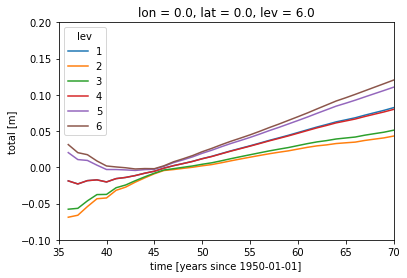

In [5]:
# check plot, can be removed
fig, ax = plt.subplots()
for i in range(1, 7):
    knmi_low_ds['total'].sel(lev=i).plot(x='time', ax=ax, label=i)
ax.set_xlim(35, 70)
ax.set_ylim(-0.1, 0.2)
ax.legend(title='lev')

In [6]:
# convert to dataframe
# lookup confidence bands an compute total land ice budgets
knmi_dfs = {}
for name, ds in [('low', knmi_low_ds), ('high', knmi_high_ds)]:
    knmi_df = ds.to_dataframe().reset_index()
    # epoch is 1950
    knmi_df['year'] = knmi_df['time'] + 1950
    # Antarctica
    knmi_df['aa'] = knmi_df['dyn_aa'] + knmi_df['smb_aa']
    # Geenland
    knmi_df['gre'] = knmi_df['dyn_gre'] + knmi_df['smb_gre']
    # levels are mean,p05,p10,p50,p90,p95,
    knmi_df_mean = knmi_df.query('lev == 1')
    knmi_df_p05 = knmi_df.query('lev == 2')
    knmi_df_p95 = knmi_df.query('lev == 6')
    
    knmi_df = pd.merge(
        pd.merge(knmi_df_mean, knmi_df_p05, on='time', suffixes=('', '_p05')),
        knmi_df_p95, 
        on='time',
        suffixes=('_mean', '_p95')
    )
    knmi_df['year'] = knmi_df['year_mean']
    knmi_dfs[name] = knmi_df


In [7]:
# find overlapping period
year_min = max(knmi_dfs['high']['year'].min(), observed_df['time'].min())
year_max = min(knmi_dfs['high']['year'].max(), observed_df['time'].max())
year_min, year_max

(1986.0, 2018)

In [8]:
# apply selection
for name, knmi_df in knmi_dfs.items():
    knmi_dfs[name] = knmi_df[(knmi_df.year >= year_min) & (knmi_df.year <= year_max)]
observed_df = observed_df[(observed_df.year >= year_min) & (observed_df.year <= year_max)]

In [9]:
def plot_budgets(knmi_var='', observed_var=''):
    """this function generates a combined figure of the different components of the local sea-level rise """
    fig, ax = plt.subplots(figsize=(13, 5))

    
    if knmi_var:
        for key, knmi_df in knmi_dfs.items():
            knmi_reference = knmi_df.query('year >= 1986 and year <= 2005')[knmi_var + '_mean'].mean()
            print('knmi reference level', knmi_reference)
            knmi_mean = (knmi_df[knmi_var + '_mean'] - knmi_reference ) * 100
            knmi_p05 = (knmi_df[knmi_var + '_p05'] - knmi_reference) * 100
            knmi_p95 = (knmi_df[knmi_var + '_p95'] - knmi_reference) * 100
            ax.fill_between(x=knmi_df['year'], y1=knmi_p05, y2=knmi_p95, facecolor=colors[key] + (0.2, ))
            ax.plot(knmi_df['year'], knmi_mean, color=colors[key], label=f"{labels[key]}: {knmi_var.lower()}")

    if observed_var:
        observed_reference = observed_df.query('year >= 1986 and year <= 2005')[observed_var].mean()
        observed_total = observed_df[observed_var] - observed_reference
        print('observed reference', observed_reference)
        sns.regplot(x=observed_df['year'], y=observed_total.values, ax=ax, order=1, color=colors['observed'], label=f"{labels['observed']}: {observed_var.lower()}", ci=90)

    ax.set_ylabel('')
    # fix the limits so all plots are comparable
    ax.set_ylim(-5, 15)
    ax.axis('off')
    ax.legend(loc='upper left')
    return fig, ax


knmi reference level -0.00061746436
knmi reference level 0.0021893873
observed reference 4.993676045765435


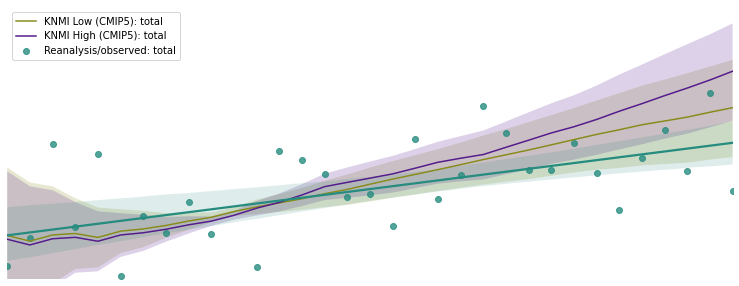

In [10]:
# total
fig, ax = plot_budgets(knmi_var='total', observed_var='Total')

knmi reference level 0.0021197964
knmi reference level 0.003882148
observed reference 3.1066854344512107


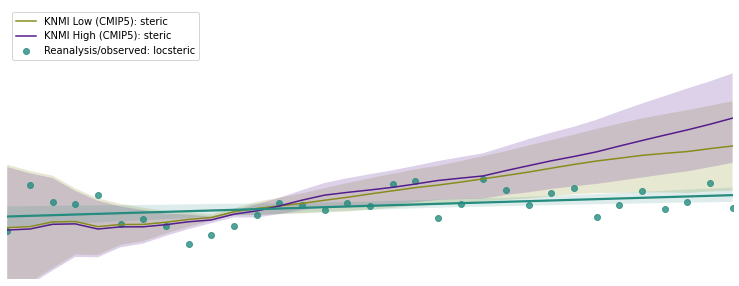

In [11]:
# Local Steric (scenarios only have 1 steric)
plot_budgets(knmi_var='steric', observed_var='LocSteric');

knmi reference level 0.0015249619
knmi reference level 0.0043318137
observed reference 1.011068007946014


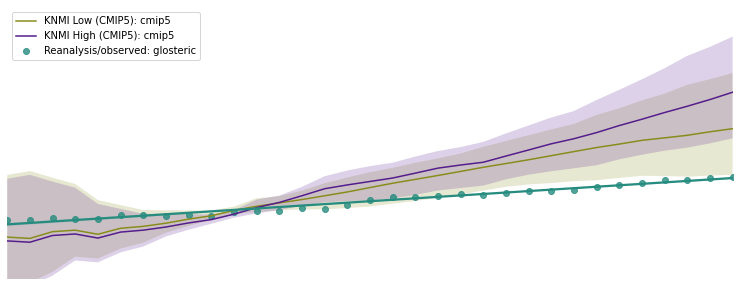

In [12]:
# Global steric
plot_budgets(knmi_var='cmip5', observed_var='GloSteric');

observed reference 0.60775


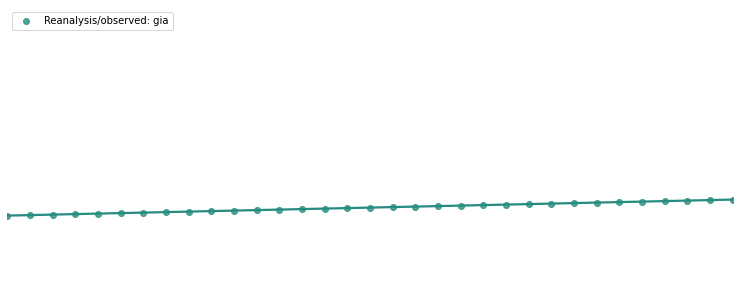

In [13]:
# GIA
plot_budgets(knmi_var='', observed_var='GIA');

knmi reference level 0.00043143268
knmi reference level 0.0003580797
observed reference 0.12387497797608375


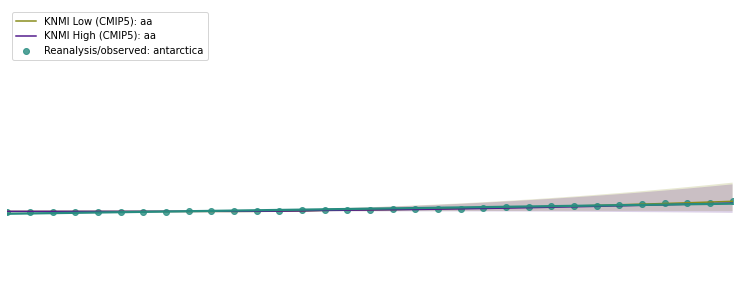

In [14]:
plot_budgets(knmi_var='aa', observed_var='Antarctica');

knmi reference level -4.376707e-06
knmi reference level 7.7857985e-06
observed reference 0.0319166670863827


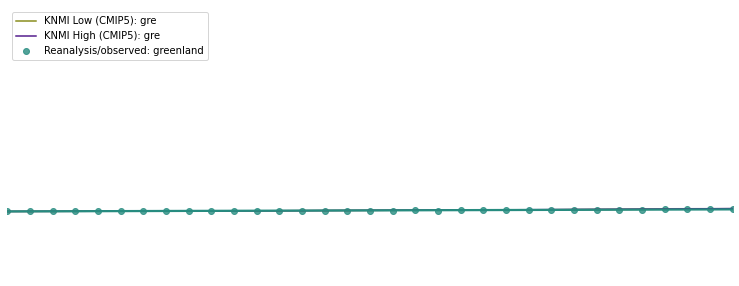

In [15]:
plot_budgets(knmi_var='gre', observed_var='Greenland');

observed reference 0.14537500963391115


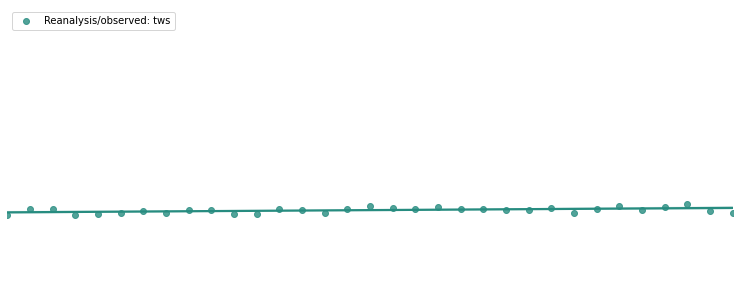

In [16]:
# Water storage
plot_budgets(observed_var='TWS');


observed reference 0.5700329992985941


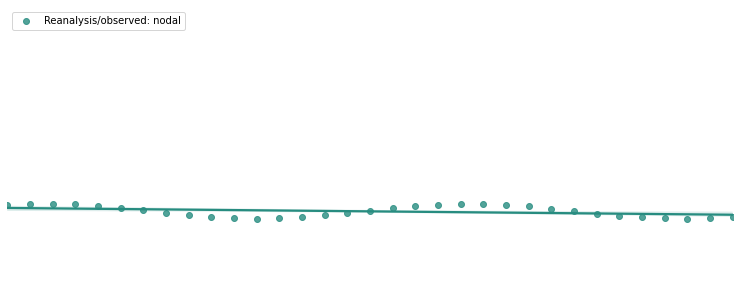

In [17]:
# Nodal tide is not present in projections
plot_budgets(knmi_var='', observed_var='Nodal');


observed reference -1.8942194584405052


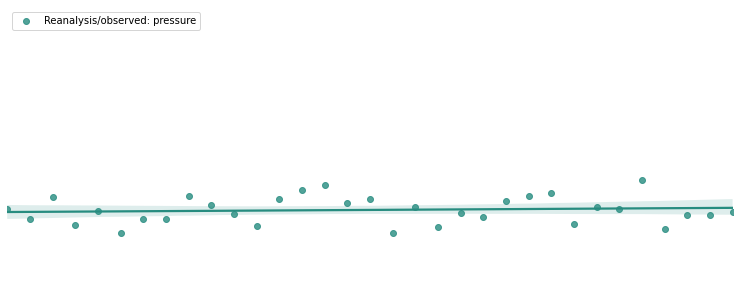

In [18]:
# Inverse Barometer Effect (will be replaced with GTSM) (in gtsm-surge notebook)
plot_budgets(knmi_var='', observed_var='Pressure');


observed reference 0.6858173684846122


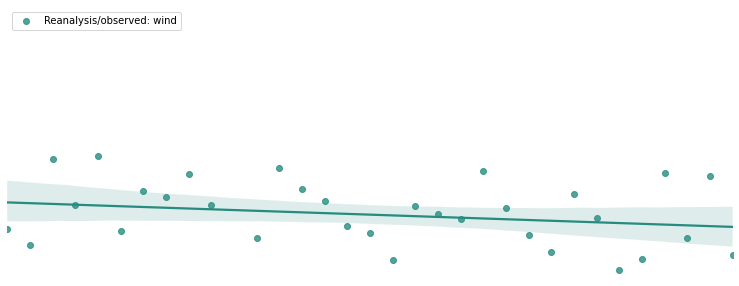

In [19]:
# Wind (will be replace with GTSM) (in gtsm-surge notebook)
plot_budgets(knmi_var='', observed_var='Wind');
